# Install packages and import necessary libraries

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Preprocess data

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import os

pd.set_option('display.max_columns', None)

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import and visualize data
test_data = pd.read_excel('/content/Embedded_Lies_for_ML.csv', sep=';')
print(f"Dataset shape: {test_data.shape}")
test_data.head()

Dataset shape: (1042, 131)


,Participant_id,Fluent_languages,Age,Sex,Nationality,Language,Student status,Employment status,Duration_sec,Duration_min,List_of_events,Event,Title_event,Time_event,Recollection_event,Importance_event,Accuracy_event,Valence_event,Task_order,True_event,True_event_tokens,True_event_clean,True_event_num_words,False_event,False_event_tokens,False_event_clean,False_event_num_words,Embedded_lies_1,Embedded_lies_2,Embedded_lies_3,Embedded_lies_4,Embedded_lies_5,Embedded_lies_6,Embedded_lies_7,Embedded_lies_8,Embedded_lies_9,Embedded_lies_10,Embedded_lies_11,Embedded_lies_12,Embedded_lies_13,Embedded_lies_14,Embedded_lies_15,Embedded_lies_16,Embedded_lies_17,Embedded_lies_18,Embedded_lies_19,Embedded_lies_20,1_deceptive,1_central,1_source,2_deceptive,2_central,2_source,3_deceptive,3_central,3_source,4_deceptive,4_central,4_source,5_deceptive,5_central,5_source,6_deceptive,6_central,6_source,7_deceptive,7_central,7_source,8_deceptive,8_central,8_source,9_deceptive,9_central,9_source,10_deceptive,10_central,10_source,11_deceptive,11_central,11_source,12_deceptive,12_central,12_source,13_deceptive,13_central,13_source,14_deceptive,14_central,14_source,15_deceptive,15_central,15_source,16_deceptive,16_central,16_source,17_deceptive,17_central,17_source,18_deceptive,18_central,18_source,19_deceptive,19_central,19_source,20_deceptive,20_central,20_source,EL_abs_num,merged_lies,merged_lies_tokens,merged_lies_clean,EL_num_words,EL_stand_num,deceptiveness,centrality,Difficulty,Motivation_truth,Motivation_deception,Clear_instructions,LIE_Ability,LIE_Frequency,LIE_Negativity,LIE_Contextuality,SDE,IM,BIDR,LIE_Ability_adj,LIE_Contextuality_adj,LIE_Frequency_adj,LIE_Negativity_adj,LIE_Profile
0,660687a02630547fb296d754,"Croatian, English, Serbian",25.0,Male,Croatia,Croatian,Yes,Part-Time,2101,35.016667,"Being involved in a car accident,A job intervi...",Taking the bus/train without the ticket,Taking the bus/train without the ticket,5,1,2,3,0.5,TL,I was in a city nearby my hometown. I was goin...,i was in a city nearby my hometown i was going...,city nearby hometown go application process jo...,191,I was in a city nearby my hometown. I was goin...,i was in a city nearby my hometown i was going...,city nearby hometown go application process jo...,194,a lot of people came on the bus,a lot of people left the bus,The decision was to check the tickets/bus pass...,I was caught and had to pay double the price o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,4,Exp_Self,5.0,4.0,Exp_Self,5.0,5.0,NotExp_Self,5.0,5.0,Exp_Self,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,a lot of people came on the bus a lot of peopl...,a lot of people came on the bus a lot of peopl...,lot people come bus lot people leave bus decis...,37,0.190722,5.00,4.50,2,4,5,5,9.00,2.50,7.75,10.00,4.250,4.000,4.1250,2.852843,2.937870,-0.962676,-0.189194,Trickster
1,65391353897d68dd53a067da,"English, Greek",31.0,Female,Greece,Greek,No,Full-Time,928,15.466667,"Being hospitalised and undergoing surgery,Endi...",Ending a long romantic relationship,Ending a long romantic relationship,18,5,5,5,-1.0,TL,It was a 5 year relationship and we were very ...,it was a 5 year relationship and we were very ...,5 year relationship attached cheat lie find go...,153,It was a 5 year relationship and we were extre...,it was a 5 year relationship and we were extre...,5 year relationship extremely attach cheat lie...,148,she caught me,we had a huge fight,we fought about me going through her phone.,make it seem like we were breaking up because ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,5,NotExp_Self,2.0,1.0,Exp_Self,4.0,5.0,NotExp_Self,4.0,3.0,Exp_Self,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Test the fine-tuned model

In [ ]:
# Load the model
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained(f'/content/drive/MyDrive/PhD project/Tilburg University/Embedded Lies/flan-t5-base', from_tf=True)

/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
All TF 2.0 model weights were used when initializing T5ForConditionalGeneration.

Some weights of T5ForConditionalGeneration were not initialized from the TF 2.0 model and are newly initialized: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define a Tokenizer
from transformers import AutoTokenizer

checkpoint = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
def evaluate_model_per_label(texts, conditions, tokenizer, model):
    """
    Evaluates the model's predictions on provided texts and conditions

    Parameters:
    - texts (array-like): An array-like structure containing the texts to be evaluated.
    - conditions (array-like): An array-like structure containing the conditions (labels) for the texts.
    - tokenizer: The tokenizer used to convert text data into input IDs for the model.
    - model: The trained model used to generate predictions.

    Returns:
    - predictions_array (np.array): An array of model predictions.
    - prob_array (np.array): An array of model predictions probabilities.
    - true_labels_array (np.array): An array of true labels from the test data.
    """

    predictions = []
    true_labels = []
    probs = []

    # Iterate over each text and corresponding condition
    for text_input, true_condition in zip(texts, conditions):
        # Tokenize the text and convert to input IDs
        input_ids = tokenizer(text_input, return_tensors="pt").input_ids

        # Generate output from the model
        model_output = model.generate(input_ids, return_dict_in_generate=True, output_scores=True)
        prob = np.max(np.exp(model_output.scores)/np.sum(np.exp(model_output.scores)))

        # Decode the generated tokens to text
        decoded_predictions = tokenizer.batch_decode(model_output.sequences, skip_special_tokens=True)

        # Append the first prediction (assuming the batch size is 1 per loop iteration)
        predictions.append(decoded_predictions[0])
        true_labels.append(true_condition)
        probs.append(prob)

    # Convert lists to numpy arrays for further analysis or metrics evaluation
    predictions_array = np.array(predictions)
    probs_array = np.array(probs)
    true_labels_array = np.array(true_labels)


    return predictions_array, probs_array, true_labels_array

In [ ]:
# Define texts and conditions
texts = test_data['Text_event']
conditions = test_data['Condition']

# Run the predictions and prin the outputs
predictions, probs_array, true_labels = evaluate_model_per_label(
     texts,
     conditions,
     tokenizer,
     model)

test_data['Classifier_pred'] = predictions
test_data['Classifier_prob'] = probs_array

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
test_data

,Participant_id,EL_abs_num,EL_stand_num,deceptiveness,centrality,fabrication_source,Condition,Text_event,Condition_labels,Classifier_pred,Classifier_prob
0,660687a02630547fb296d754,4,0.190722,5.000000,4.500000,2.000000,Truthful,I was in a city nearby my hometown. I was goin...,0,T,0.695442
1,65391353897d68dd53a067da,4,0.202703,3.250000,3.500000,3.000000,Truthful,It was a 5 year relationship and we were very ...,0,T,0.822386
2,615b2ee8616d1b05551794ee,8,0.705882,5.000000,1.250000,5.000000,Truthful,It was on the 14th of February when I walked i...,0,T,0.988242
3,616dc201c0b58a25890f4b94,4,0.542553,3.250000,3.000000,5.000000,Truthful,My partner and I were in a long distance relat...,0,T,0.990052
4,5b6034ba0ced0a00017ba9b9,1,0.165217,4.000000,4.000000,3.000000,Truthful,we had to plan a celebration for our departmen...,0,F,0.495310
...,...,...,...,...,...,...,...,...,...,...,...
2079,60fbf1d8a1d6bf084f981660,5,0.248908,3.800000,3.200000,2.600000,Deceptive,coming back from work on the day of losing her...,1,T,0.969274
2080,611acc1d8ef0468018d77f76,6,0.711230,4.333333,3.166667,3.333333,Deceptive,"The day was 7 january 2024, it was a Sunday. T...",1,T,0.999436
2081,661624e5595c233a68a3963b,1,0.019608,3.000000,3.000000,1.000000,Deceptive,I was given a specific task at work by a consu...,1,T,0.909607
2082,658c1f91c0e5d908b094430e,4,0.183784,4.250000,4.250000,4.000000,Deceptive,It was because of a close experience with my f...,1,F,0.791857


# Evaluate performance

In [ ]:
# Adjust predictions
test_data['Classifier_pred'] = test_data['Classifier_pred'].map({'T': 'Truthful', 'F': 'Deceptive'})

test_data['Correct_predictions'] = test_data['Condition'] == test_data['Classifier_pred']
test_data.head()

,Participant_id,EL_abs_num,EL_stand_num,deceptiveness,centrality,fabrication_source,Condition,Text_event,Condition_labels,Classifier_pred,Classifier_prob,Correct_predictions
0,660687a02630547fb296d754,4,0.190722,5.00,4.50,2.0,Truthful,I was in a city nearby my hometown. I was goin...,0,Truthful,0.695442,True
1,65391353897d68dd53a067da,4,0.202703,3.25,3.50,3.0,Truthful,It was a 5 year relationship and we were very ...,0,Truthful,0.822386,True
2,615b2ee8616d1b05551794ee,8,0.705882,5.00,1.25,5.0,Truthful,It was on the 14th of February when I walked i...,0,Truthful,0.988242,True
3,616dc201c0b58a25890f4b94,4,0.542553,3.25,3.00,5.0,Truthful,My partner and I were in a long distance relat...,0,Truthful,0.990052,True
4,5b6034ba0ced0a00017ba9b9,1,0.165217,4.00,4.00,3.0,Truthful,we had to plan a celebration for our departmen...,0,Deceptive,0.495310,False


              precision    recall  f1-score   support

   Deceptive       0.60      0.35      0.44      1042
    Truthful       0.54      0.77      0.63      1042

    accuracy                           0.56      2084
   macro avg       0.57      0.56      0.54      2084
weighted avg       0.57      0.56      0.54      2084



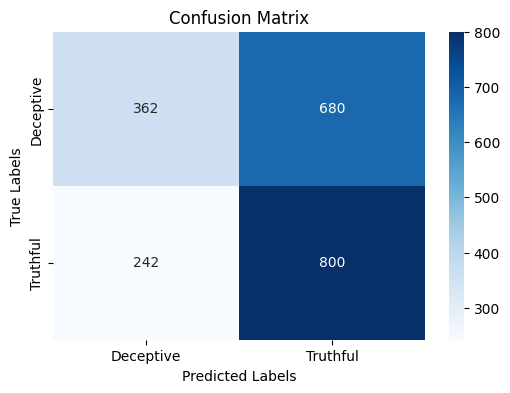

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compute and plot the confusion matrix and classification metrics

# Convert 'Condition' and 'Classifier_pred' to Truthful and Deceptivr
#test_data['Condition'] = test_data['Condition'].map({0:'Truthful', 1:'Deceptive'})
#test_data['Classifier_pred'] = test_data['Classifier_pred'].map({'T':'Truthful', 'F':'Deceptive'})

print(classification_report(test_data['Condition'], test_data['Classifier_pred'], target_names=['Deceptive', 'Truthful']))
cm = confusion_matrix(test_data['Condition'], test_data['Classifier_pred'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Deceptive', 'Truthful'], yticklabels=['Deceptive', 'Truthful'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the dataset
test_data.to_csv('/content/deception_language_model_predictions.csv', sep = ',', index=False)
test_data.to_excel('/content/deception_language_model_predictions.xlsx', index=False)